# Gradient comparison between objective functions

## Author: M. Ravasi

This notebook presents a systematic comparison of different objective functions implemented in ``devitofwi``, with their corresponding adjoint source and gradients. 

In [34]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from devito import configuration
from pylops.basicoperators import Diagonal, Identity

from tqdm.notebook import tqdm
from examples.seismic import AcquisitionGeometry, Model, Receiver
from examples.seismic import plot_velocity, plot_perturbation
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_shotrecord

from devitofwi.devito.utils import clear_devito_cache
from devitofwi.waveengine.acoustic import AcousticWave2D
from devitofwi.preproc.masking import TimeSpaceMasking
from devitofwi.loss.l2 import L2, L2Torch
from devitofwi.loss.xcorr import XCorrTorch
from devitofwi.postproc.acoustic import create_mask_value, PostProcessVP

configuration['log-level'] = 'ERROR'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
clear_devito_cache()

## Parameters 

In [21]:
# Model and aquisition parameters
par = {'nx':601,   'dx':0.015,   'ox':0,
       'nz':221,   'dz':0.015,   'oz':0,
       #'ns':2,    'ds':6.000,   'os':1.,  'sz':0,
       #'ns':3,    'ds':3.000,   'os':1.,  'sz':0,
       'ns':20,    'ds':0.300,   'os':1.,  'sz':0,
       'nr':300,   'dr':0.030,   'or':0,   'rz':0,
       'nt':3000,  'dt':0.002,   'ot':0,
       'freq':5,
      }

# Modelling parameters
shape = (par['nx'], par['nz'])
spacing = (par['dx'], par['dz'])
origin = (par['ox'], par['oz'])
space_order = 4
nbl = 20

# Velocity model
path = '../../data/'
velocity_file = path + 'Marm.bin'

# Time-space mask parameters
vwater = 1.5
toff = 0.45

## Acquisition set-up

In [4]:
# Sampling frequency
fs = 1 / par['dt'] 

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1]

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz']

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz']

## Velocity model

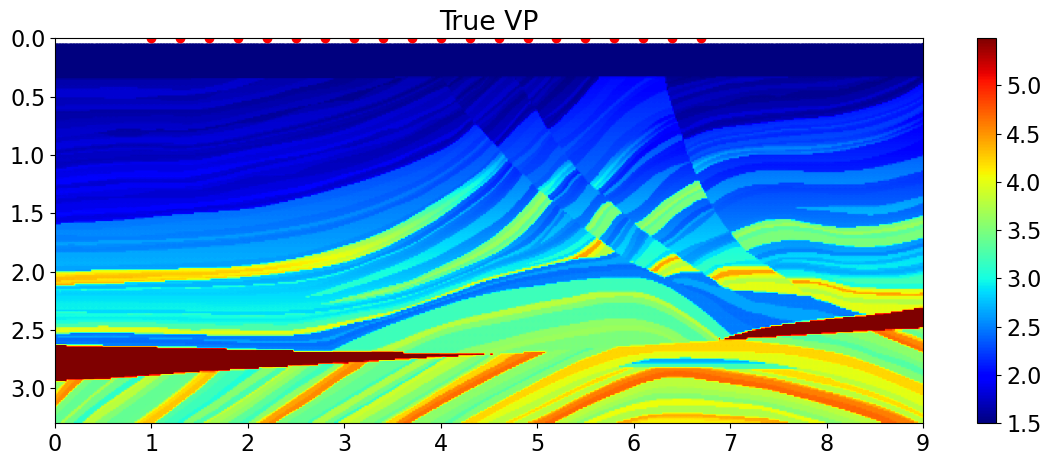

In [5]:
# Load the true model
vp_true = np.fromfile(velocity_file, np.float32).reshape(par['nz'], par['nx']).T
msk = create_mask_value(vp_true, 1.52) # get the mask for the water layer 

m_vmin, m_vmax = np.percentile(vp_true, [2,98]) 

plt.figure(figsize=(14, 5))
plt.imshow(vp_true.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('True VP')
plt.axis('tight');

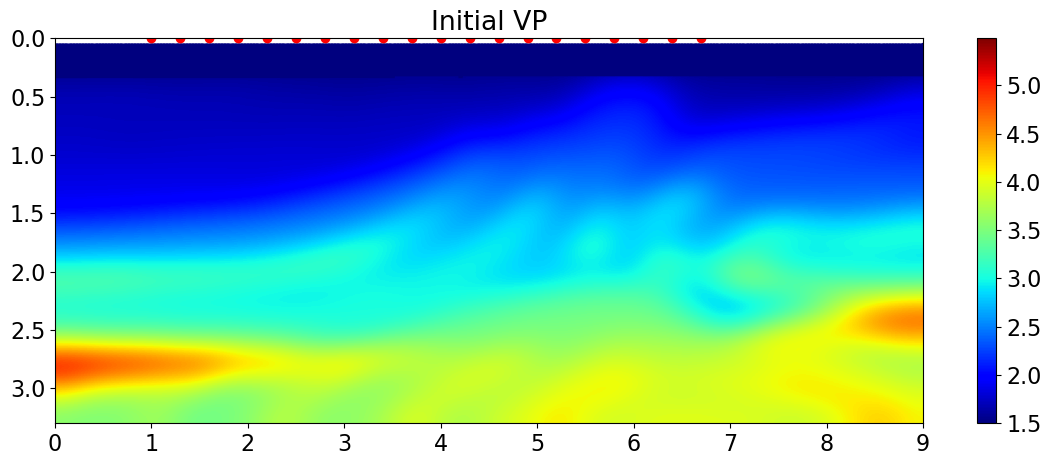

In [6]:
# Initial model for FWI by smoothing the true model
vp_init = gaussian_filter(vp_true, sigma=[15,10])
vp_init = vp_init * msk  # to preserve the water layer  
vp_init[vp_init == 0] = 1.5

plt.figure(figsize=(14, 5))
plt.imshow(vp_init.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Initial VP')
plt.axis('tight');

## Data modelling

In [13]:
# Define modelling engine
amod = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,  
                      vp=vp_true, 
                      src_type="Ricker", f0=par['freq'],
                      space_order=space_order, nbl=nbl)

# Create model and geometry to extract useful information
model, geometry = amod.model_and_geometry()

In [10]:
# Model data
dobs = amod.mod_allshots()[0]

  0%|          | 0/20 [00:00<?, ?it/s]

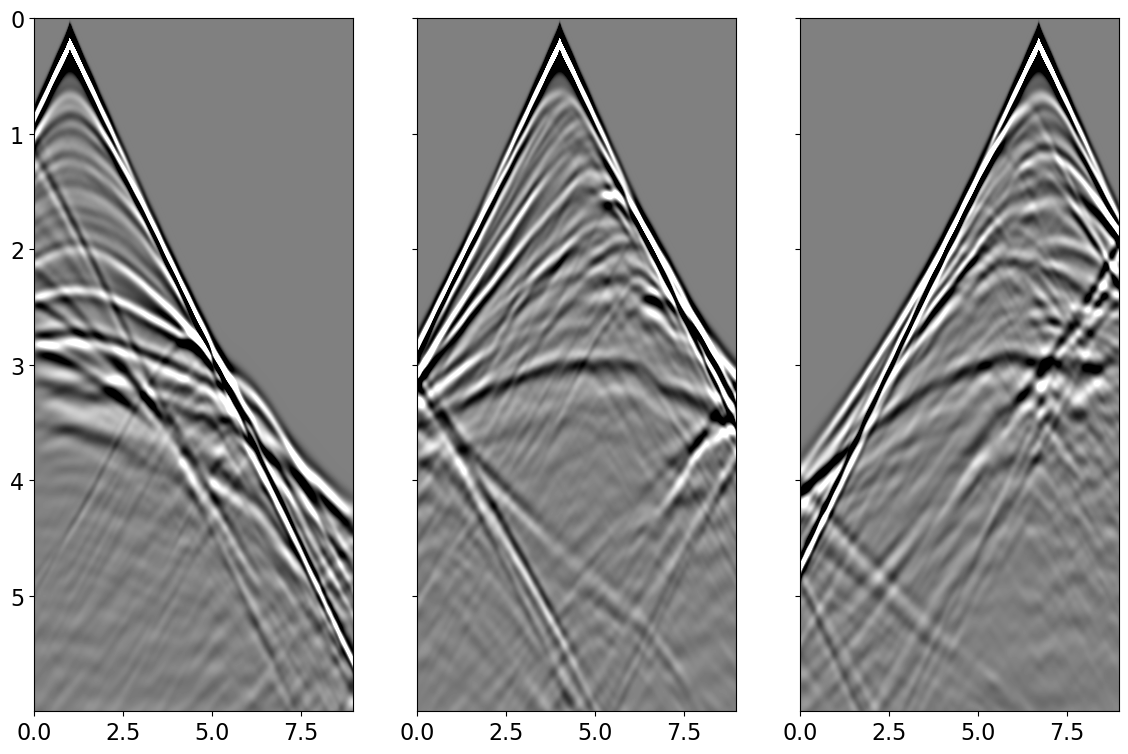

In [11]:
# Plot shot gathers
d_vmin, d_vmax = np.percentile(np.hstack(dobs).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot], aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax)

## Mask creation

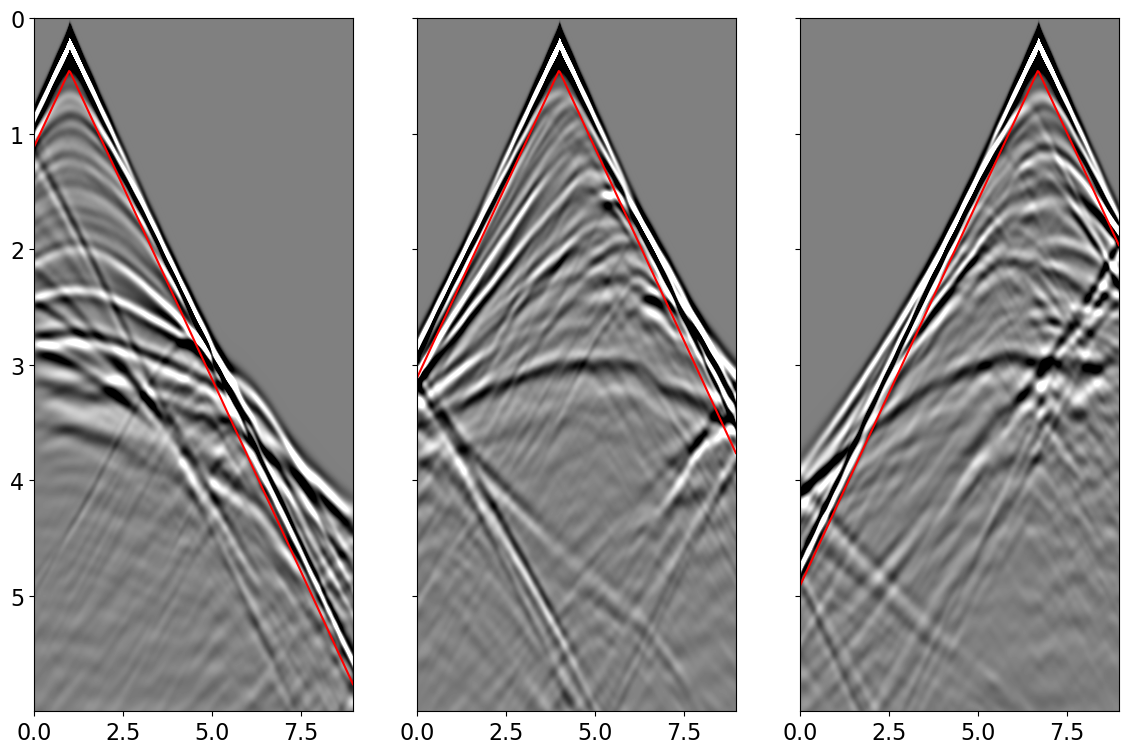

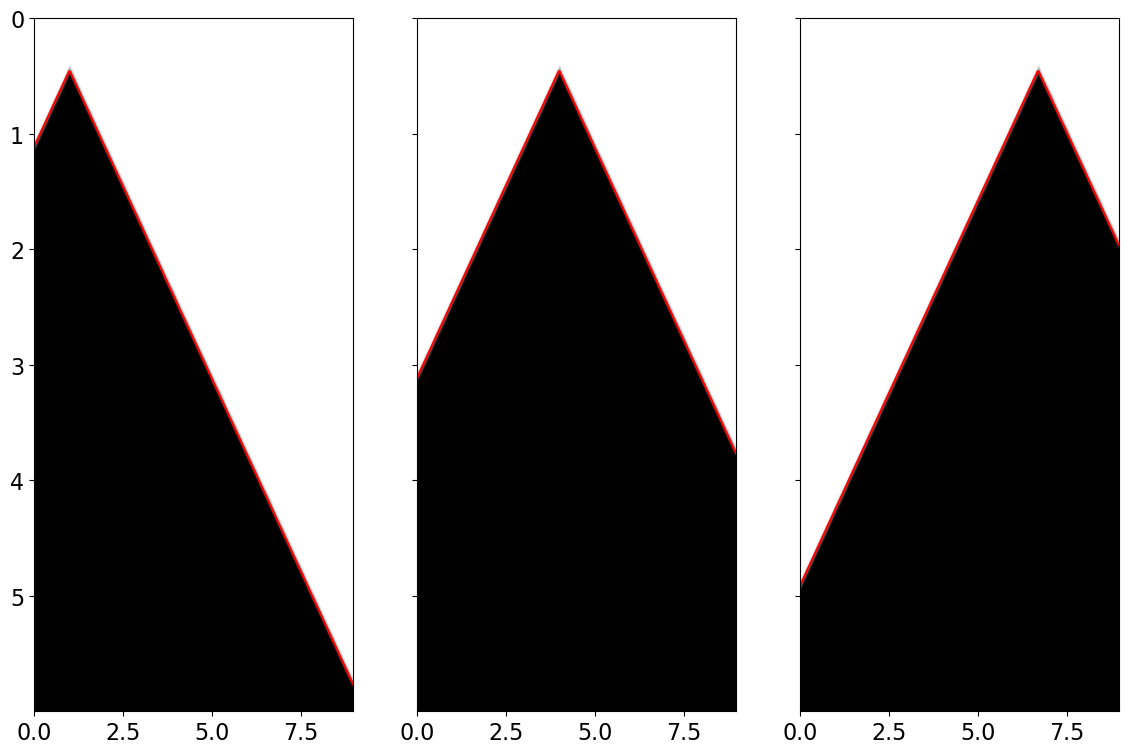

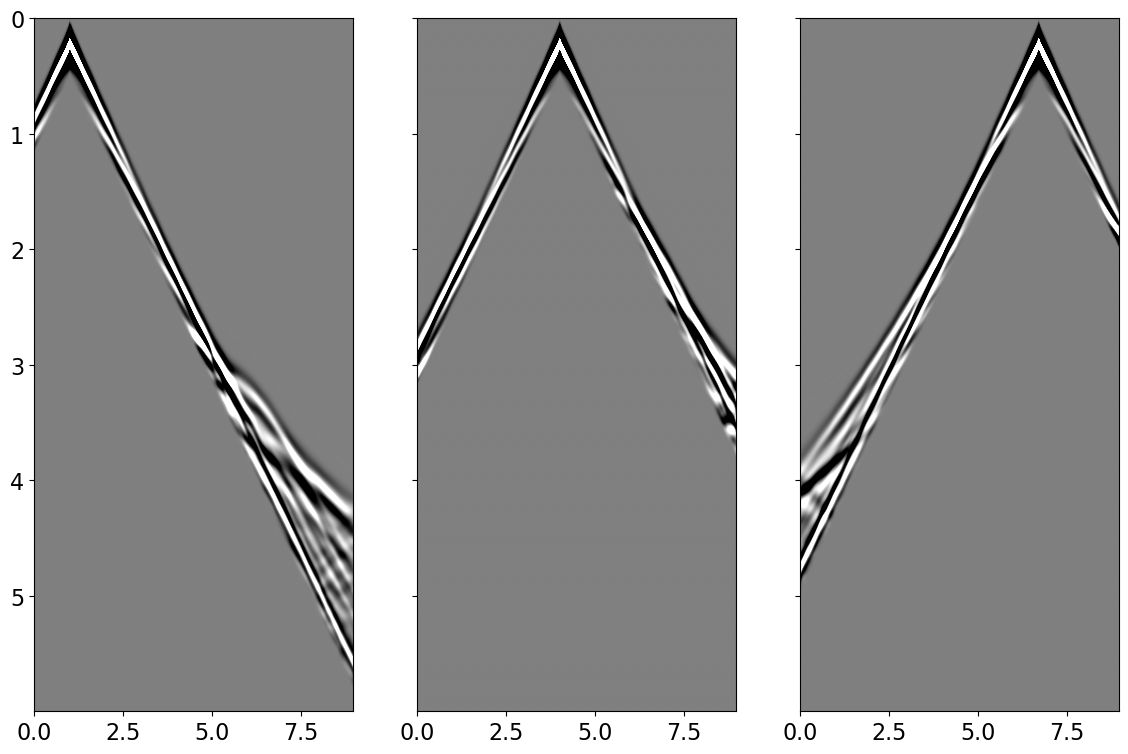

In [22]:
# Create direct arrival mask
distance = np.sqrt((x_s[:, 0][:, None]-x_r[:, 0][None, :])**2 + (x_s[:, 1][:, None]-x_r[:, 1][None, :])**2)
directtime = distance / vwater
tsmask = TimeSpaceMasking(directtime, geometry.nt, geometry.dt, toff, nsmooth=50)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot], aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax)
    ax.plot(x_r[:, 0], (directtime[ishot] + toff), 'r')
    
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(tsmask.mask[ishot].T, aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=0, vmax=1)
    ax.plot(x_r[:, 0], (directtime[ishot] + toff), 'r')
    
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot] * tsmask.mask[ishot].T, aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax);

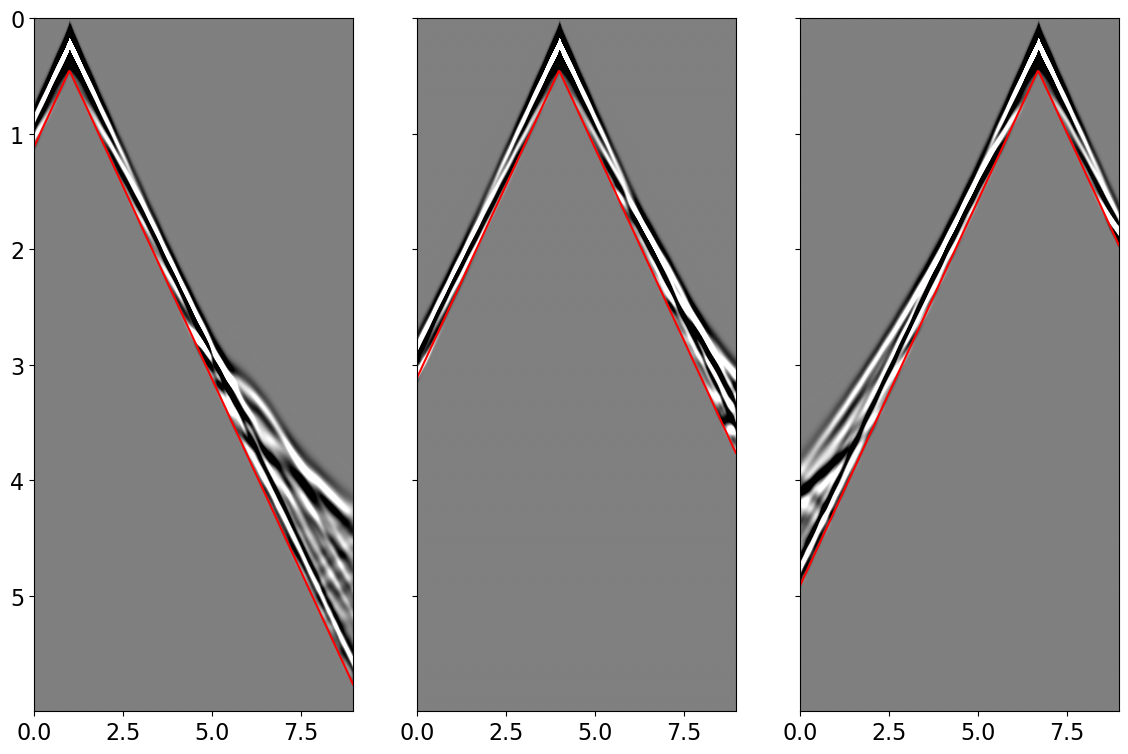

In [25]:
# Mask observed data to have direct arrival and refractions only
TSmaskop = [Diagonal(tsmask.mask[isrc].T.ravel()) for isrc in range(par['ns'])]
dobs_masked = np.hstack([(TSmaskop[isrc] @ dobs[isrc].ravel())[None, :] for isrc in range(par['ns'])])
dobs_masked = dobs_masked.reshape(par['ns'], geometry.nt, par['nr'])

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs_masked[ishot], aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax)
    ax.plot(x_r[:, 0], (directtime[ishot] + toff), 'r')

## L2

In [35]:
# Define loss (to which we can add the mask as a diagonal linear operator applied to the modelled data
l2loss = L2(TSmaskop, dobs_masked.reshape(par['ns'], -1))
# l2loss = L2Torch(dobs_masked.reshape(par['ns'], -1), TSmaskop)

wav = geometry.src.wavelet
ainv = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,  
                      vprange=(vp_true.min(), vp_true.max()),
                      #src_type="Ricker", f0=par['freq'],
                      wav=wav, f0=par['freq'],
                      space_order=space_order, nbl=nbl,
                      loss=l2loss)

  0%|          | 0/20 [00:00<?, ?it/s]

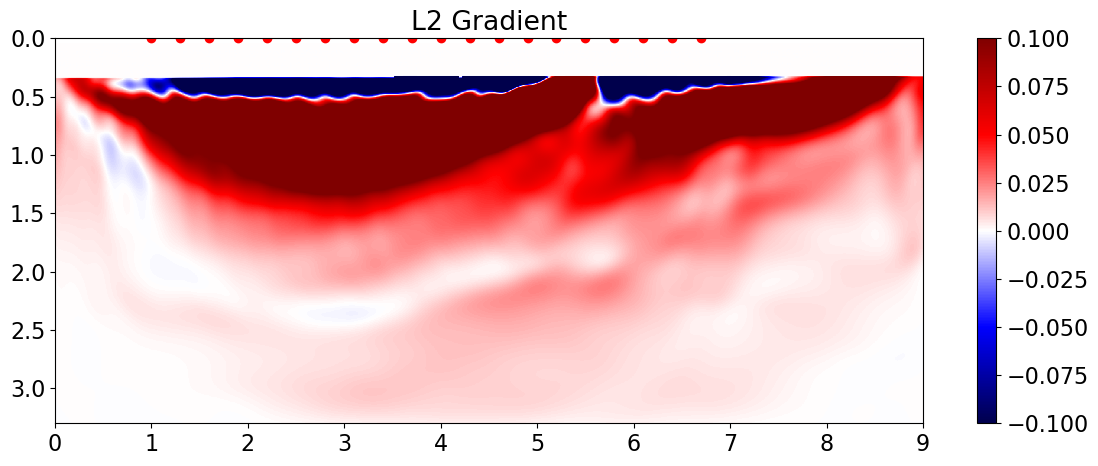

In [36]:
# Compute first gradient and find scaling
postproc = PostProcessVP(scaling=1, mask=msk)
_, directionl2 = ainv._loss_grad(vp_init, postprocess=postproc.apply)

scalingl2 = directionl2.max()

plt.figure(figsize=(14, 5))
plt.imshow(directionl2.T / scalingl2, cmap='seismic', vmin=-1e-1, vmax=1e-1, 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('L2 Gradient')
plt.axis('tight');

## XCorr


In [38]:
# Define loss (to which we add the mask as a diagonal linear operator applied to the modelled data
xcorrloss = XCorrTorch(TSmaskop, dobs_masked.reshape(par['ns'], -1), par['nr'], geometry.nt)

wav = geometry.src.wavelet
ainv = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,  
                      vprange=(vp_true.min(), vp_true.max()),
                      #src_type="Ricker", f0=par['freq'],
                      wav=wav, f0=par['freq'],
                      space_order=space_order, nbl=nbl,
                      loss=xcorrloss);

  0%|          | 0/20 [00:00<?, ?it/s]

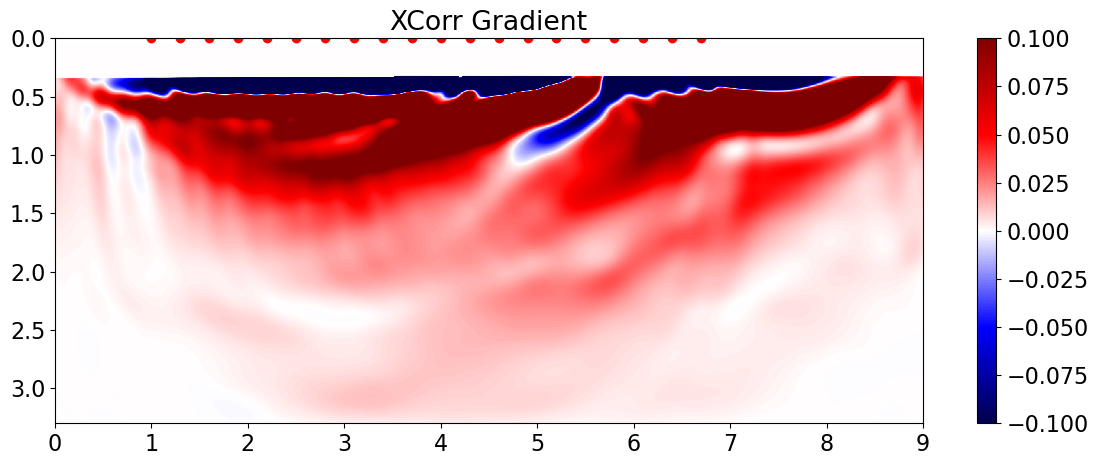

In [39]:
# Compute first gradient and find scaling
postproc = PostProcessVP(scaling=1, mask=msk)
_, directionxcorr = ainv._loss_grad(vp_init, postprocess=postproc.apply)

scalingxcorr = directionxcorr.max()

plt.figure(figsize=(14, 5))
plt.imshow(directionxcorr.T / scalingxcorr, cmap='seismic', vmin=-1e-1, vmax=1e-1, 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('XCorr Gradient')
plt.axis('tight');

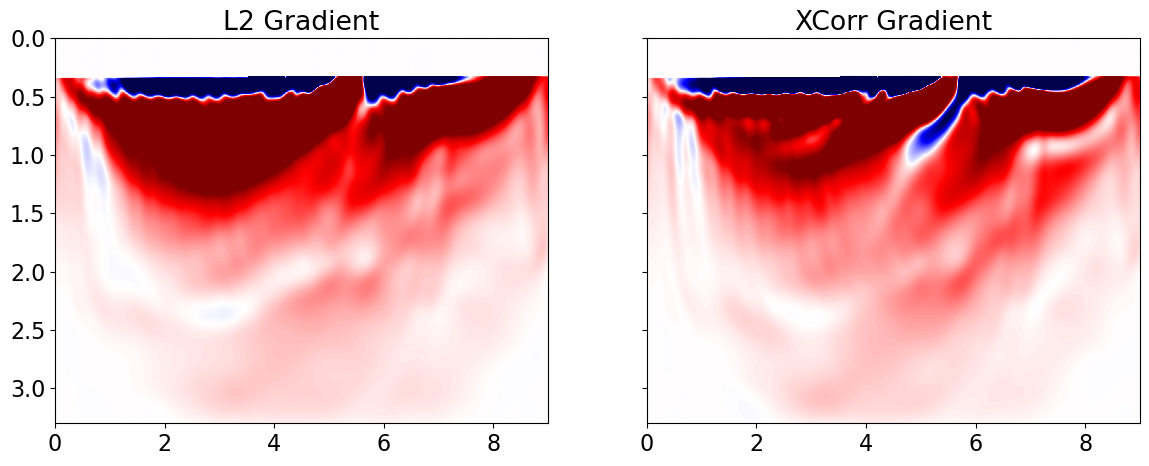

In [40]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14, 5))
axs[0].imshow(directionl2.T / scalingl2, cmap='seismic', vmin=-1e-1, vmax=1e-1, 
           extent=(x[0], x[-1], z[-1], z[0]))
axs[0].set_title('L2 Gradient')
axs[0].axis('tight')
axs[1].imshow(directionxcorr.T / scalingxcorr, cmap='seismic', vmin=-1e-1, vmax=1e-1, 
           extent=(x[0], x[-1], z[-1], z[0]))
axs[1].set_title('XCorr Gradient')
axs[1].axis('tight');